<a href="https://colab.research.google.com/github/Grigorus/Study_Stepik/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D1%82%D0%B8%D0%BA%D0%B8_%D1%81%D0%BE%D0%B1%D0%B0%D1%87%D0%BA%D0%B8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU, Flatten # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam, RMSprop # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google
import PIL
import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем
import matplotlib.pyplot as plt 
%matplotlib inline
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model

### **ПОДГОТОВКА И ОБРАБОТКА ДАННЫХ ДЛЯ ПОДАЧИ В СЕТЬ**

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resx, resy, resz = 220,220,3 #задаём размер, в который будем делать resize наших картинок

In [ ]:
def marker(animalimage, xmin, ymin, xmax, ymax):#функция для разметки фоточек
    draw = ImageDraw.Draw(animalimage)
    draw.rectangle([xmin, ymin, xmax, ymax], outline='red' )
    return animalimage

In [ ]:
def recalculator (content, x, y, resx, resy, xmin, ymin, xmax, ymax): # создаём функцию пересчёта bouding box после resize
    contentres = np.zeros(5, dtype = int)
    contentres[0] = content[0]
    contentres[1] = int((xmin/x)*resx)
    contentres[3] = int((xmax/x)*resx)
    contentres[2] = int((ymin/y)*resy)
    contentres[4] = int((ymax/y)*resy)
    return contentres

In [ ]:
def resizer(animalfiledig, resx, resy):#создаём функцию преобразования размера картинки
    animalres = animalfiledig.resize((resx,resy), Image.BICUBIC)
    return animalres

In [ ]:
union = []  #создаём массив с классами животных и пересчитанных координат боксов изменённых файлов 
digitalanimal = [] #создаём массив, в котором будут храниться наши коты и собаки изменённого размера
i = 0
for filename in os.listdir(f'/content/drive/MyDrive/pitonism/cat_dog_detection/text_cat_dog/'):
        stringname = f'/content/drive/MyDrive/pitonism/cat_dog_detection/text_cat_dog/{filename}'
        filepicname = filename[:-3]+'jpg'
        animalimage = Image.open (f'/content/drive/MyDrive/pitonism/cat_dog_detection/picture_cad_dog/{filepicname}')
        x,y = animalimage.size  #получаем размер текущей картинки
        with open(f'{stringname}', "r") as file:#открываем файл с первоначальными координатами
            content = file.read()#читаем файл с первоначальными координатами
            content = content.split(' ')#разделяем строку через пробелы на отдельные стринг
            content = np.array(content, dtype = int)#преобразуем str в int
            xmin, ymin, xmax, ymax = content [1:]#получаем исходные координаты для преобразования
            union.append(recalculator (content, x, y, resx, resy, xmin, ymin, xmax, ymax))#пересчёт  и добавление координат
        animalfiledig = marker(animalimage, xmin, ymin, xmax, ymax) #размечаем голову и преобразуем каждую картинку в Numpy массив
        animalarr = np.array(resizer (animalfiledig, resx, resy))
        digitalanimal.append(animalarr)
        
        i=i+1
        print(i)
#digitalanimal = np.array(digitalanimal)
union = np.array(union)

In [ ]:
digitalanimal [2502] = digitalanimal [2503]

In [ ]:
digitalanimal = np.array(digitalanimal)

In [ ]:
#np.save('/content/drive/MyDrive/pitonism/cat_dog_detection/union.npy', union)# сохраняем массив
#np.save('/content/drive/MyDrive/pitonism/cat_dog_detection/digitalanimal.npy', digitalanimal)# сохраняем массив

In [ ]:
union = np.load ('/content/drive/MyDrive/pitonism/cat_dog_detection/union.npy')
digitalanimal = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/digitalanimal.npy')
print (union.shape)
print (digitalanimal.shape)

(3385, 5)
(3385, 220, 220, 3)


In [ ]:
animclass = np.zeros(3385)
animbbox = []
for i in range (0,3385):
      animbbox.append(union[i,1:5])
      if union [i,0] == 1:
        animclass[i] = 1
      elif union [i,0]== 2:
        animclass[i]  = 0
      else: print ('index', i, 'error contained', sep=' ')
animclass = np.array(animclass, dtype = int)
animbbox  = np.array(animbbox, dtype = int)
print ('animclass shape=', animclass.shape)
print ('animbbox shape=', animbbox.shape)

animclass shape= (3385,)
animbbox shape= (3385, 4)


In [ ]:
i = 0
digitalanimal = [] #создаём массив, в котором будут храниться наши коты и собаки
for filename in os.listdir(f'/content/drive/MyDrive/pitonism/cat_dog_detection/picture_cad_dog'):
    animalimage = Image.open (f'/content/drive/MyDrive/pitonism/cat_dog_detection/picture_cad_dog/{filename}')
    animalfiledig = np.array(animalimage) #преобразуем каждую картинку в Numpy массив
    animalres = np.resize(animalfiledig, (220,220,3)) #приводим все картинки к указанному в ТЗ размеру
    digitalanimal.append(animalres)
    i= i+1
    print (i)
digitalanimal = np.array(digitalanimal) #преобразуем в nparray итоговый список

In [ ]:
print (animalarray.shape)

(3385, 220, 220, 3)


In [ ]:
#np.save('/content/drive/MyDrive/pitonism/cat_dog_detection/animalarray.npy', digitalanimal) #сохраняем массив
animalarray = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/animalarray.npy')

In [ ]:
animal = Image.open ('/content/drive/MyDrive/pitonism/cat_dog_detection/picture_cad_dog/Abyssinian_11.jpg')
with open('/content/drive/MyDrive/pitonism/cat_dog_detection/text_cat_dog/Abyssinian_11.txt', "r") as file:
          content = file.read()
          content = content.split(' ')
          content = np.array(content, dtype = int)
          xmin, ymin, xmax, ymax = content [1:]
print (xmin, ymin, xmax, ymax)          

43 57 94 105


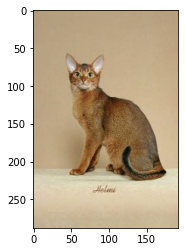

In [ ]:
plt.imshow(animal)

192 288


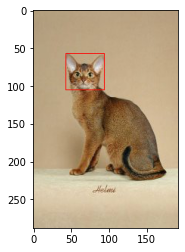

In [ ]:
x,y = animal.size
draw = ImageDraw.Draw(animal)
draw.rectangle([xmin, ymin, xmax, ymax], outline='red' )
plt.imshow(animal)
print (x,y)

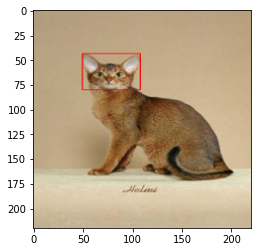

In [ ]:
resx, resy = 220,220 #задаём размер, в который будем делать resize наших картинок
image1 = animal.resize((resx, resy), Image.BICUBIC) # Изменяем размер исходного изображения
plt.imshow(image1) # Рисуем изображение

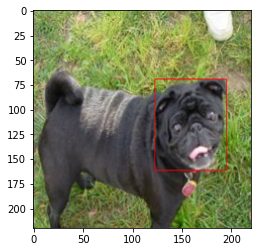

In [ ]:
plt.imshow(digitalanimal[2000])

[  2  21  14 200 112]
0
[ 21  14 200 112]


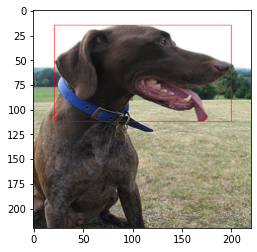

In [ ]:
tx=3001
plt.imshow(digitalanimal[tx])#проверяем случайный преобразованный файл
print (union[tx])# и пересчитанный боундингбокс с классом.
print (animclass[tx])
print (animbbox[tx])

In [ ]:
x_train_animal = digitalanimal[385:]  #разделение выборок
x_test_animal = digitalanimal[:385]
y_train_bounding = animbbox [385:]
y_test_bounding = animbbox [:385]
y_train_class = animclass [385:]
y_test_class = animclass [:385]

In [ ]:
#@title Текст заголовка по умолчанию
list_of_dataname = ['x_train_animal', 'x_test_animal', 'y_train_bounding', 'y_test_bounding', 'y_train_class', 'y_test_class']
listmassive = [x_train_animal, x_test_animal, y_train_bounding, y_test_bounding, y_train_class, y_test_class]

In [ ]:
i=0
for dat in list_of_dataname:
  np.save(f'/content/drive/MyDrive/pitonism/cat_dog_detection/{dat}.npy', listmassive[i]) #сохраняем массивы
  i=i+1

###  **НАЧАЛО НОВОЙ СЕССИИ И ЗАГРУЗКА ПОДГОТОВЛЕННЫХ ВЫБОРОК ИЗ GOOOGLE DRIVE**

In [ ]:
x_train_animal     = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/x_train_animal.npy')
x_test_animal     = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/x_test_animal.npy')
y_train_bounding = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/y_train_bounding.npy')
y_test_bounding = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/y_test_bounding.npy')
y_train_class = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/y_train_class.npy')
y_test_class = np.load('/content/drive/MyDrive/pitonism/cat_dog_detection/y_test_class.npy')

In [ ]:
print (x_train_animal.shape)   #контроль размерностей выборок после загрузки
print (x_test_animal.shape)
print (y_train_bounding.shape)
print (y_test_bounding.shape)
print (y_train_class.shape)
print (y_test_class.shape)

(3000, 220, 220, 3)
(385, 220, 220, 3)
(3000, 4)
(385, 4)
(3000,)
(385,)


In [ ]:
listmassive = [x_train_animal, x_test_animal, y_train_bounding, y_test_bounding, y_train_class, y_test_class]

In [ ]:
for dat in listmassive:
        print (dat.dtype)

int64
int64
int64
int64
int64
int64


In [ ]:
x_train_animal = x_train_animal.astype(int)
x_test_animal = x_test_animal.astype(int)

In [ ]:
def IoU(pred, y):
  xminp = pred [:,0]
  yminp = pred [:,1]
  xmaxp = pred [:,2]
  ymaxp = pred [:,3]
  xmint = y [:,0]
  ymint = y [:,1]
  xmaxt = y [:,2]
  ymaxt = y [:,3]
  ht = ymaxt-ymint
  wt = xmaxt-xmint
  hp = ymaxp-yminp
  wp = xmaxp-xminp
  top_left1 = xminp  # Получаем значение, соответствующее верхнему левому углу
  right_bottom1 = xmint # Получаем значение, соотвествующее правому нижнему углу
        

  top_left2 = ymaxp # Получаем значение, соответствующее верхнему левому углу
  right_bottom2 = ymaxt # Получаем значение, соотвествующее правому нижнему углу
         
  intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
  intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
  intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
  intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
        
  area1 = K.multiply(ht * wt) # Считаем площадь первых элементов
  area2 = K.multiply(hp * wp) # Считаем площадь вторых элементов
        
  return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU
    
 


In [ ]:
  xminp, yminp, xmaxp, ymaxp = y_train_bounding[2000]
  xmint, ymint, xmaxt, ymaxt = y_train_bounding[2500]
  ht = ymaxt-ymint
  wt = xmaxt-xmint
  hp = ymaxp-yminp
  wp = xmaxp-xminp
  top_left1 = xminp  # Получаем значение, соответствующее верхнему левому углу
  right_bottom1 = xmint # Получаем значение, соотвествующее правому нижнему углу
        

  top_left2 = ymaxp # Получаем значение, соответствующее верхнему левому углу
  right_bottom2 = ymaxt # Получаем значение, соотвествующее правому нижнему углу
         
  intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
  intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
  intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0) # Считаем ширину и высоту области пересечения
  intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
        
  area1 = ht * wt # Считаем площадь первых элементов
  area2 = hp * wp # Считаем площадь вторых элементов
        
  print (intersect_area / (area1 + area2 - intersect_area)) # Возвращаем IoU

In [ ]:
print (K.maximum(xminp, yminp))

tf.Tensor(105, shape=(), dtype=int64)


In [ ]:
print (max(xminp, yminp))

105


### НЕЙРОНКА КОТИКИ-СОБАЧКИ

In [ ]:
inp = Input(shape = (220,220,3))
x = Conv2D (32, (2,2), padding = 'same')(inp)
x = Conv2D (32, (2,2), padding = 'same')(x)
x = Conv2D (16, (2,2), padding = 'same')(x)
x = Conv2D (8, (2,2), padding = 'same')(x)
x = Flatten()(x)
#x = Dense (512, activation = 'relu')(x)
#x = Dense (256, activation = 'relu')(x)
x = Dense (64, activation = 'relu')(x)
out1 = Dense (4, activation = 'relu')(x)
out2 = Dense (1, activation = 'sigmoid')(x)

animalmodel = Model (inputs = [inp], outputs = [out1, out2])

In [ ]:
animalmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 220, 220, 32) 416         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 220, 220, 32) 4128        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 220, 220, 16) 2064        conv2d_5[0][0]                   
____________________________________________________________________________________________

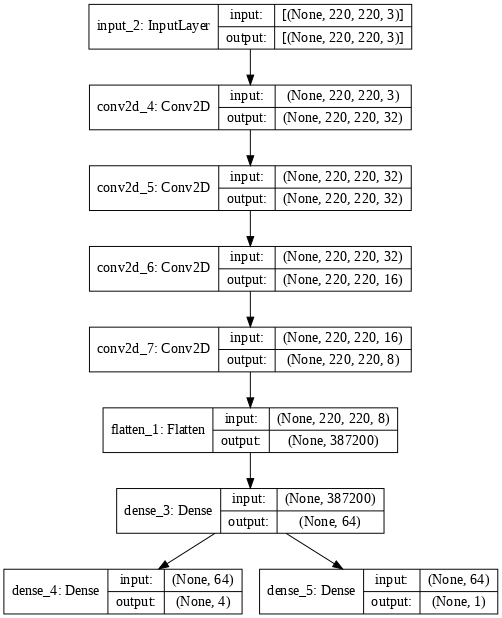

In [ ]:
plot_model(animalmodel, dpi=70, show_shapes=True, show_layer_names=True)

In [ ]:
animalmodel.compile(optimizer=Adam(lr=1e-4), #компилируем сеть
              loss= [IoU,'binary_crossentropy'],
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = animalmodel.fit(x_train_animal,  
                     [y_train_bounding, y_train_class],
                    epochs = 50,
                    batch_size=5,
                    validation_data=(x_test_animal, [y_test_bounding, y_test_class]))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/50


TypeError: ignored

In [ ]:
'''
    Функция подсчета IoU
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    #input1 = input1.astype('tf.int64')
    xy1 = input1[..., :2] # Получаем координаты x,y центра 
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соотвествующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    #input2 = input2.astype('tf.int64')
    xy2 = input2[..., :2] # Получаем координаты x,y центра 
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соотвествующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU
    